# Задача
[Соревнование](https://www.kaggle.com/competitions/sberbank-russian-housing-market/overview)

Данные предоставлены Сбербанком, старейшим и крупнейшим банком России. Прогнозирование стоимости недвижимости является критически важной задачей для клиентов банка — арендаторов, застройщиков и кредиторов. Точный прогноз позволяет лучше планировать бюджеты и снижать риски. Сбербанк проводит это соревнование, чтобы привлечь сообщество специалистов по машинному обучению и данным для разработки наиболее точных моделей, способных учесть сложные взаимосвязи между характеристиками жилья и макроэкономическими факторами.

Список фичей из топ-20 с краткими описаниями
- num_room: количество комнат в квартире
- full_sq: общая площадь квартиры (кв. м)
- sport_count_5000: количество спортивных объектов в радиусе 5 км
- sport_count_3000: количество спортивных объектов в радиусе 3 км
- trc_count_5000: количество торгово-развлекательных центров (ТРЦ) в радиусе 5 км
- zd_vokzaly_avto_km: расстояние до ближайшего автовокзала (км)
- sadovoe_km: расстояние до Садового кольца (км)
- kremlin_km: расстояние до Кремля — центра Москвы (км)
- bulvar_ring_km: расстояние до Бульварного кольца (км)
- sport_count_2000: количество спортивных объектов в радиусе 2 км
- ttk_km: расстояние до Третьего транспортного кольца (км)
- office_sqm_5000: общая площадь офисных помещений в радиусе 5 км
- trc_sqm_5000: суммарная площадь ТРЦ в радиусе 5 км
- sport_count_1500: количество спортивных объектов в радиусе 1.5 км
- nuclear_reactor_km: расстояние до ближайшего ядерного объекта (км)
- sport_objects_raion: число спортивных объектов в районе
- trc_count_3000: количество ТРЦ в радиусе 3 км
- cafe_count_5000_price_1000: количество кафе в радиусе 5 км со средним чеком до 1000 руб.
- stadium_km: расстояние до ближайшего стадиона (км)
- cafe_count_5000_price_1500: количество кафе в радиусе 5 км со средним чеком до 1500 руб.

In [ ]:
import os
import random
import sys
import time
import warnings
from pathlib import Path
from typing import List, Optional, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import skew
from tqdm import tqdm
from IPython.display import HTML, display

import category_encoders as ce
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor, Pool

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import StackingRegressor

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.validation.np_iterators import FoldsIterator
from lightautoml.tasks import Task

# Настройки
%matplotlib inline

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

SEED = 22


def set_all_seeds(seed: int = 22):
    """задаем фиксированный seed"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    print(f"Random seed set to {seed}")


set_all_seeds(SEED)

Random seed set to 22


Часто используемые функции

In [62]:
def find_categorical_features(
    df: pd.DataFrame,
    max_unique: int = 20,
    exclude: list[str] | None = None
) -> dict:
    """
    Находит категориальные признаки в DataFrame.
    
    Возвращает словарь с ключами:
    - 'object': явные категориальные (object)
    - 'numeric': числовые с <= max_unique уникальных значений
    - 'total': объединенный список категориальных признаков
    """
    if exclude is None:
        exclude = []

    # Явные категориальные (object)
    cat_object = df.select_dtypes(include=['object']).columns.tolist()

    # Числовые колонки
    numeric_cols = df.select_dtypes(include=[np.number, np.float32]).columns.tolist()

    cat_numeric = []
    for col in numeric_cols:
        if col in exclude:
            continue
        unique_count = int(df[col].nunique(dropna=True))
        if unique_count <= max_unique:
            cat_numeric.append(col)

    # Убираем возможные пересечения и сортируем
    cat_object = sorted([c for c in cat_object if c not in exclude])
    cat_numeric = sorted([c for c in cat_numeric if c not in cat_object and c not in exclude])

    categorical_total = cat_object + cat_numeric
    return {
        'object': cat_object,
        'numeric': cat_numeric,
        'total': categorical_total
    }


def dprint(title: str, df: pd.DataFrame) -> None:
    """Отображает датафрейм с заголовком в HTML-формате"""

    display(HTML(f"<h3>{title}</h3>"))
    display(df)

In [63]:
DATA_DIR = Path("./data/raw")

# Загрузка данных
train_data = pd.read_csv(DATA_DIR / "train.csv")
test_data = pd.read_csv(DATA_DIR / "test.csv")
macro_data = pd.read_csv(DATA_DIR / "macro.csv")

# Объединение с макроэкономическими данными
train_data = pd.merge(train_data, macro_data, how="left", on="timestamp")
test_data = pd.merge(test_data, macro_data, how="left", on="timestamp")

# Приведение timestamp к типу datetime
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"])
test_data["timestamp"] = pd.to_datetime(test_data["timestamp"])

# Удаляем ненужные признаки
drop_cols = ["ID_bus_terminal", "ID_railroad_terminal", "id"]
train_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (30471, 388)
Test shape: (7662, 387)


## EDA

### Анализ целевой переменной
Во время анализа целевого признака (price_doc) рассмотрим как изменялись цены на недвижимость с течением времени, a также проанализируем взаимосвязь с nan_count во временном промежутке, поскольку изменение количества пропусков в разные периоды может отражать взаимосвязь с ценнами недвижимости.

Это позволит понять:
- появляются ли всплески пропусков в определённые годы или месяцы;
- есть ли связь c целевой переменной.

In [ ]:
# меняем тип данных на datetime и добавим колонку с годом
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
train_data['year'] = pd.to_datetime(train_data['timestamp']).dt.year

# цена в миллионах рублей
train_data['price_mln'] = train_data['price_doc'] / 1e6

# топ-5 самых дорогих и самых дешевых сделок
top5_expensive = train_data.sort_values(by=['price_mln'], ascending=False).head(10)
top5_cheap = train_data.sort_values(by=['price_mln'], ascending=True).head(10)


# группировка по годам
yearly_stats = train_data.groupby(['year'])['price_mln'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max',
    skew='skew'
)

# вычисление выбросов по IQR c коэфф. 3
# (захватит, примерно 2%)
def get_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower = max(Q1 - 3 * IQR, 0)
    upper = Q3 + 3 * IQR
    return (group < lower) | (group > upper), lower, upper


outliers_info = []
for year in train_data['year'].unique():
    year_data = train_data[train_data['year'] == year]['price_mln']
    outliers_mask, lower, upper = get_outliers(year_data)
    outliers_count = outliers_mask.sum()
    outliers_info.append({
        'year': year,
        'outliers_count': outliers_count,
        'outliers_percent': outliers_count / len(year_data) * 100,
        'lower_bound': lower,
        'upper_bound': upper,
        'total_count': len(year_data)
    })

outliers_df = pd.DataFrame(outliers_info)

# общая маска выбросов для всех данных
train_data['is_outlier'] = train_data.groupby('year')['price_mln'].transform(
    lambda x: get_outliers(x)[0]
)

# вычисляем общую статистику выбросов
total_outliers = train_data['is_outlier'].sum()
total_percent = total_outliers / len(train_data) * 100

# Анализ статистики цен по годам
dprint(
    title="Статистика цен по годам",
    df=yearly_stats.reset_index()
)

# Топ 10 самых дорогих сделок
dprint(
    title="Топ 10 самых дорогих сделок",
    df=top5_expensive[[
        "timestamp",
        "price_mln",
        "full_sq",
        "num_room",
        "sub_area",
        "state",
        "floor",
        "raion_popul",
    ]]
)

# Топ 10 самых дешевых сделок
dprint(
    title="Топ 10 самых дешевых сделок",
    df=top5_cheap[[
        "timestamp",
        "price_mln",
        "full_sq",
        "num_room",
        "sub_area",
        "state",
        "floor",
        "raion_popul",
    ]]
)

# Анализ выбросов по годам (IQR метод)
dprint(
    title="Анализ выбросов по годам (IQR метод)",
    df=outliers_df
)

display(HTML(f"<h3>Общая статистика выбросов</h3>"
             f"<p>Всего выбросов: {total_outliers} ({total_percent:.2f}% от всех данных)</p>"
             f"<p>Выбросы определены с коэффициентом 3*IQR по каждому году отдельно</p>"))

,year,count,mean,median,std,min,max,skew
0,2011,753,5.929668,5.500,3.829036,0.34,37.000000,2.067990
1,2012,4839,6.354435,5.650,4.518082,0.19,111.111112,5.890063
2,2013,7978,6.712150,5.900,4.313564,0.26,91.066096,4.909147
3,2014,13662,7.449468,6.552,4.882734,0.10,80.777440,3.963228
4,2015,3239,8.183914,7.100,5.610930,0.50,95.122496,4.442458


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
2118,2012-05-10,111.111112,55,NaN,Teplyj Stan,NaN,12.0,130396
28326,2015-03-12,95.122496,220,9.0,Presnenskoe,3.0,3.0,123280
7457,2013-04-19,91.066096,185,NaN,Ramenki,NaN,33.0,125111
19095,2014-05-29,80.777440,184,1.0,Ramenki,4.0,10.0,125111
6319,2013-03-06,78.802248,206,NaN,Pokrovskoe Streshnevo,NaN,2.0,53786
3557,2012-09-10,77.000000,157,NaN,Mar'ina Roshha,NaN,15.0,65972
27460,2015-01-23,71.249624,151,4.0,Ajeroport,1.0,15.0,73007
11085,2013-10-08,71.200000,132,4.0,Prospekt Vernadskogo,NaN,16.0,61039
5728,2013-01-21,71.033632,210,NaN,Tverskoe,NaN,4.0,75377
29656,2015-05-12,70.000000,211,6.0,Presnenskoe,3.0,5.0,123280


,timestamp,price_mln,full_sq,num_room,sub_area,state,floor,raion_popul
20244,2014-06-27,0.100000,72,2.0,Gol'janovo,1.0,11.0,157010
1167,2012-02-11,0.190000,38,NaN,Beskudnikovskoe,NaN,9.0,73148
1169,2012-02-13,0.200000,47,NaN,Savelki,NaN,7.0,32071
9221,2013-07-16,0.260000,40,NaN,Novo-Peredelkino,NaN,1.0,111023
3258,2012-08-21,0.300000,31,NaN,Caricyno,NaN,5.0,125354
20388,2014-06-30,0.301693,63,1.0,Rostokino,1.0,11.0,37502
2677,2012-06-27,0.331464,37,NaN,Nekrasovka,NaN,4.0,19940
1596,2012-03-20,0.338570,59,NaN,Nekrasovka,NaN,5.0,19940
634,2011-12-15,0.340000,70,NaN,Matushkino,NaN,16.0,38075
1262,2012-02-21,0.354289,66,NaN,Mitino,NaN,12.0,178473


,year,outliers_count,outliers_percent,lower_bound,upper_bound,total_count
0,2011,20,2.656042,0,15.700000,753
1,2012,112,2.314528,0,16.677199,4839
2,2013,172,2.155929,0,17.414000,7978
3,2014,297,2.173913,0,19.000000,13662
4,2015,72,2.222908,0,22.086110,3239


Посмотрим на отдельные сделки недвижимости во временном промежутке

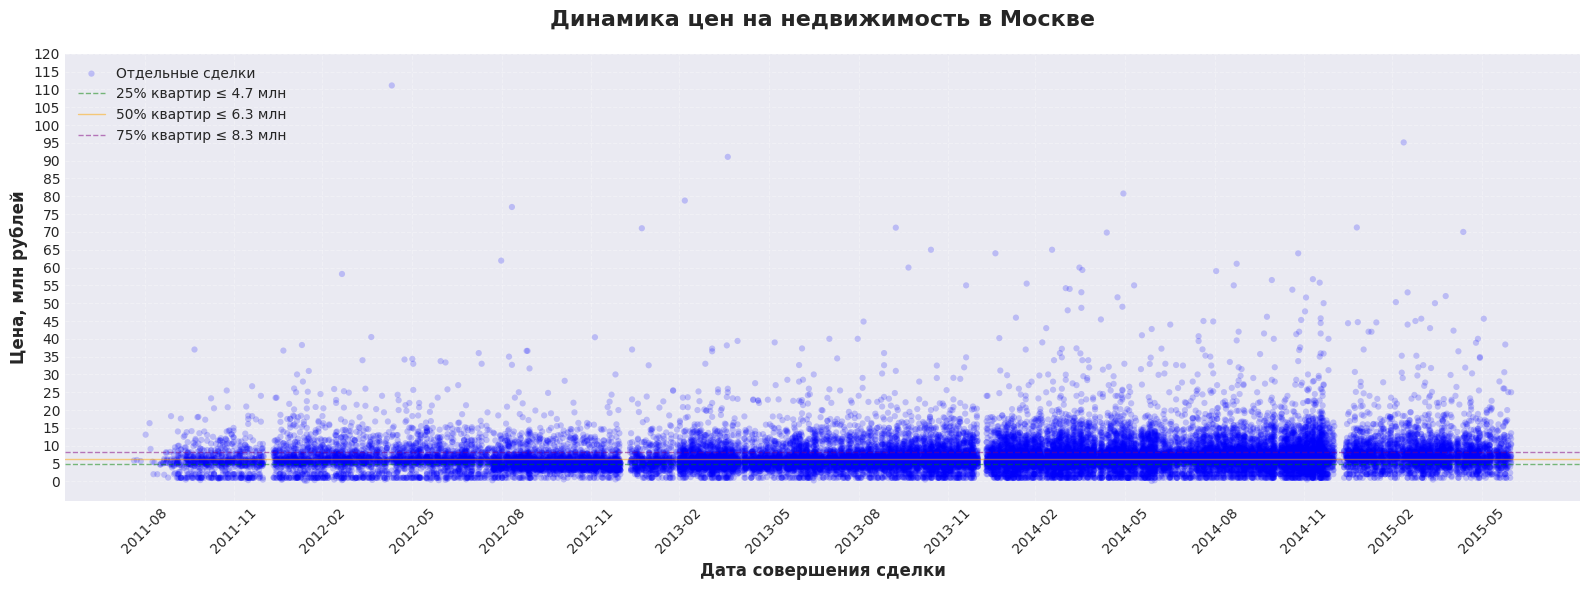

In [65]:
plt.figure(figsize=(16, 6))

# Преобразуем даты в числовой формат
dates_num = train_data["timestamp"].map(pd.Timestamp.toordinal)

# Отдельные сделки
plt.scatter(
    dates_num,
    train_data["price_mln"],
    alpha=0.2,
    s=20,
    color="blue",
    label="Отдельные сделки",
    edgecolors="none",
)

# Настройка оси X
date_ticks = pd.date_range(
    train_data["timestamp"].min(),
    train_data["timestamp"].max(),
    freq="3M",
)
plt.xticks(
    [pd.Timestamp(d).toordinal() for d in date_ticks],
    [d.strftime("%Y-%m") for d in date_ticks],
    rotation=45,
    fontsize=10,
)

# Подписи осей
plt.ylabel("Цена, млн рублей", fontsize=12, fontweight="bold")
plt.xlabel("Дата совершения сделки", fontsize=12, fontweight="bold")

# Настройка оси Y
y_ticks = np.arange(0, train_data["price_mln"].max() + 10, 5)
plt.yticks([int(y) for y in y_ticks], [f"{int(y)}" for y in y_ticks], fontsize=10)
plt.grid(True, alpha=0.3, linestyle="--")

# Добавление линий квартилей
for q, color, style in [(0.25, "green", "--"), (0.5, "orange", "-"), (0.75, "purple", "--")]:
    q_value = train_data["price_mln"].quantile(q)
    plt.axhline(
        y=q_value,
        color=color,
        linestyle=style,
        alpha=0.5,
        linewidth=1,
        label=f"{int(q*100)}% квартир ≤ {q_value:.1f} млн",
    )

# Заголовок и легенда
plt.title(
    "Динамика цен на недвижимость в Москве",
    fontsize=16,
    fontweight="bold",
    pad=20,
)
plt.legend(loc="upper left", fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

# Удаляем промежуточные признаки
train_data.drop(columns=["price_mln", "is_outlier"], inplace=True)

Теперь посмотрим на распределение плотности цен.

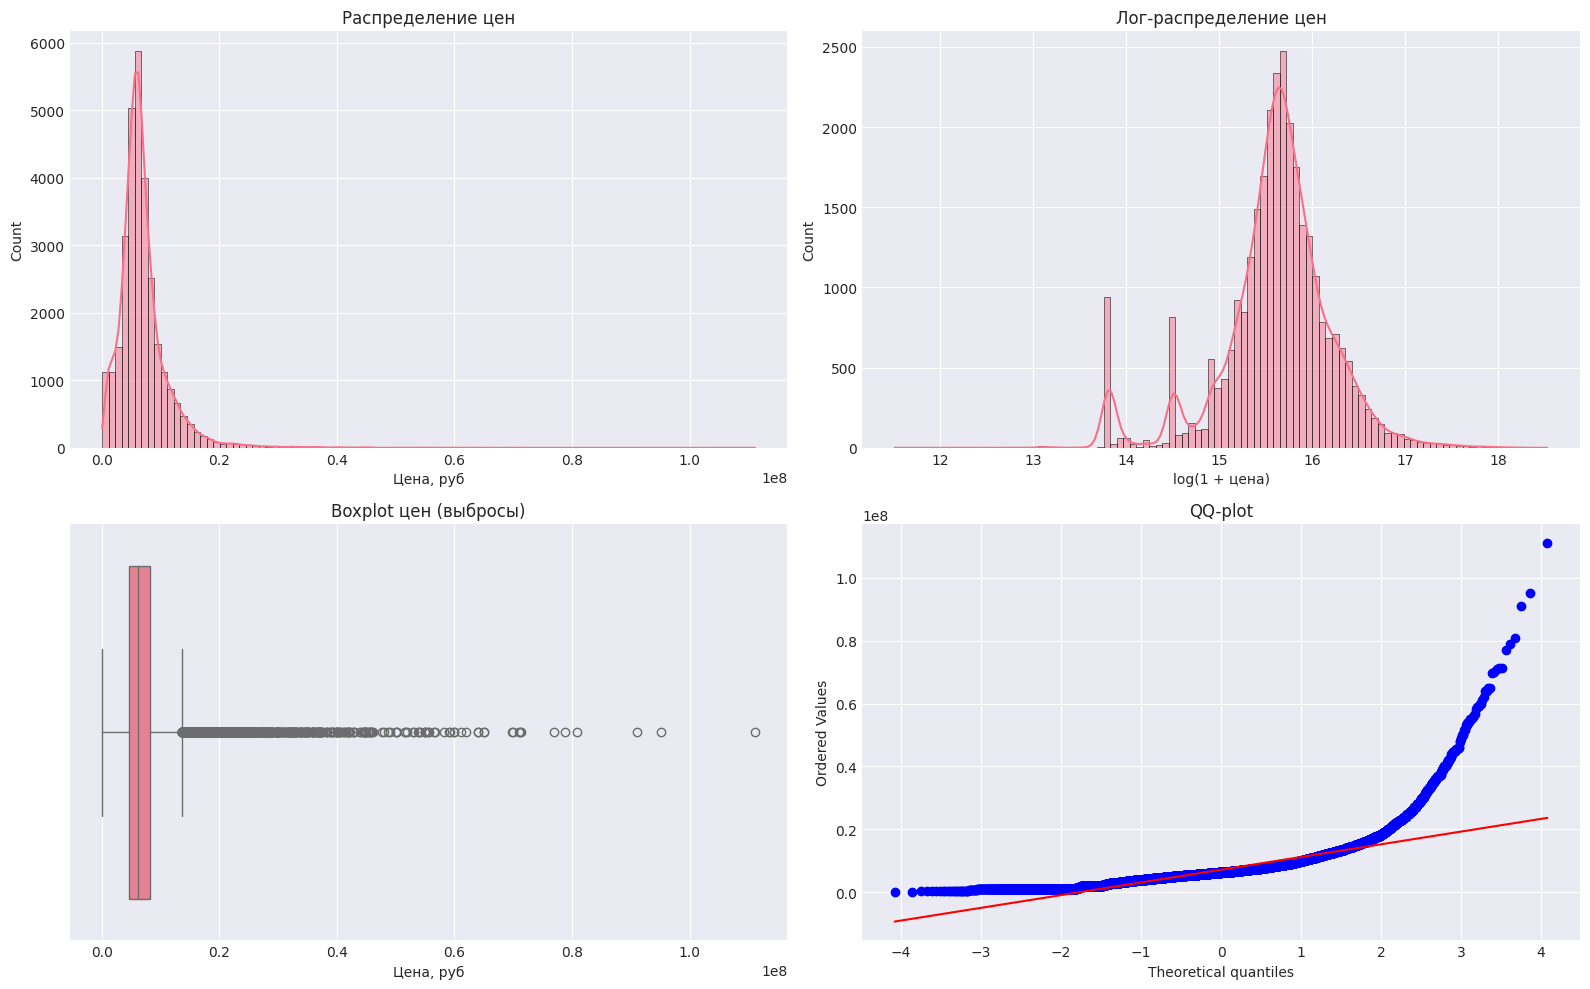

In [67]:
plt.figure(figsize=(16, 10))

# Гистограмма цены
plt.subplot(2, 2, 1)
sns.histplot(train_data['price_doc'], bins=100, kde=True)
plt.xlabel('Цена, руб')
plt.title('Распределение цен')

# Гистограмма лог-цены
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(train_data['price_doc']), bins=100, kde=True)
plt.xlabel('log(1 + цена)')
plt.title('Лог-распределение цен')

# Boxplot
plt.subplot(2, 2, 3)
sns.boxplot(x=train_data['price_doc'])
plt.title('Boxplot цен (выбросы)')
plt.xlabel('Цена, руб')

# QQ-plot
plt.subplot(2, 2, 4)
stats.probplot(train_data['price_doc'], dist="norm", plot=plt)
plt.title('QQ-plot')

plt.tight_layout()
plt.show()

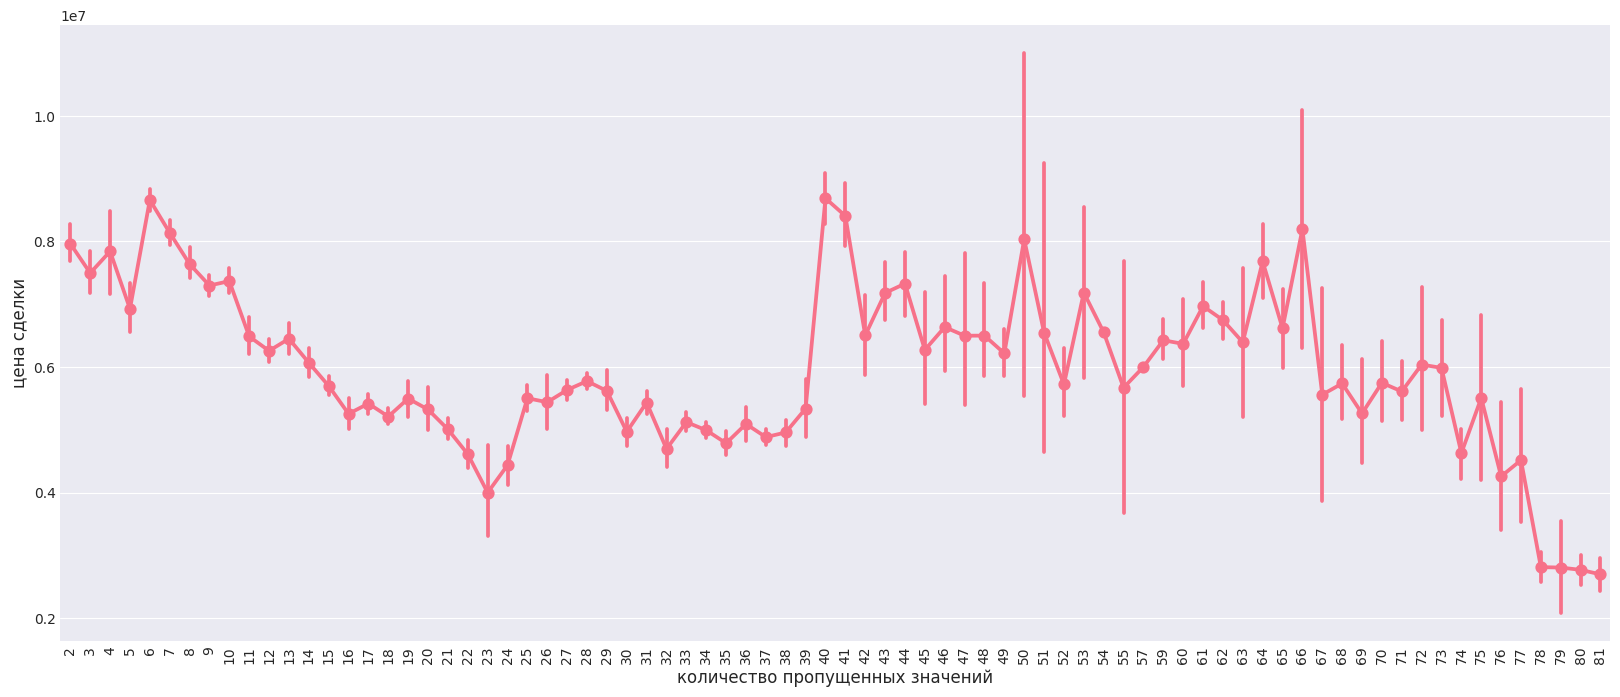

In [68]:
# посмотрим зависимость price_doc от кол. пропущенных значений
train_data['null_count'] = train_data.isnull().sum(axis=1)

plt.figure(figsize=(20, 8))
sns.pointplot(x='null_count', y='price_doc', data=train_data)
plt.ylabel('цена сделки', fontsize=12)
plt.xlabel('количество пропущенных значений', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [69]:
print('Линейная взаимосвязь между null_count и price_doc')
train_data[['null_count', 'price_doc']].corr()

Линейная взаимосвязь между null_count и price_doc


,null_count,price_doc
null_count,1.000000,-0.106369
price_doc,-0.106369,1.000000


На графике наблюдается **отрицательная корреляция** – чем больше пропущенных значений, тем меньше цена квартиры.  
_Гипотеза_: дешевые квартиры хуже описаны в БД в отличие от дорогих.

##### Выводы по анализу целевой переменной

- Рынок в 2011–2015 демонстрирует устойчивый рост цен, при этом растёт и разброс цен: появляются как более дорогие, так и более дешёвые сделки — рынок становится более неоднородным.

- Верхний хвост содержит смесь реальных элитных сделок и явных аномалий, нижний хвост тоже включает большое число некорректных записей.

- ```Skewness > 2``` — показывает сильную положительную асимметрию: распределение сильно скошено вправо. QQ-plot и значительная разница между mean и median подтверждают, что данные дальше от нормального распределения, особенно в верхнем хвосте.

- Наблюдается отрицательная корреляция пропущенных значений с целевой переменной, поэтому стоит использовать данный признак во время обучения.


Поскольку наличие выбросов искажает средние, дисперсию и метрики ошибки, из-за чего модель может "подгоняться" под редкие экстремумы и хуже предсказывать целевое значение, то стоит от подобного вида выбросов избавиться.

### Общий анализ признаков

Цели анализа признаков:

1) ```Тип данных```: определить, какие типы данных присутствуют в наборе, чтобы правильно спланировать дальнейшую обработку.
2) ```Категориальные признаки```: оценить уникальные значения и распределение категорий, чтобы выбрать подходящую стратегию кодирования (one-hot, target-encoding и еtс.), и построить кардинальность категориальных признаков;
3) ```Пропущенные значения```: оценить долю и паттерны пропусков по признакам для выбора методов их заполнения или исключения.
4) ```Коллинеарность и корреляция```: проверить линейные зависимости между признаками и целевой переменной, чтобы выявить сильно коррелирующих пар признако.

In [70]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)      
pd.set_option('display.max_colwidth', 50)   
pd.set_option('display.precision', 3)  


# Первые 5 строк тренировочных данных
dprint(
    title="Train data (первые 5 строк)",
    df=train_data.head()
)

# Статистические значения тестовых данных
dprint(
    title="Стат. значения",
    df=test_data.describe()
)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,bus_terminal_avto_km,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_count_2000,sport_count_2000,market_count_

#### Тип данных

In [9]:
print('Тип данных')
print(train_data.dtypes)

print("\nЧастота типов данных:")
print(train_data.dtypes.value_counts())

Тип данных
timestamp                    datetime64[ns]
full_sq                               int64
life_sq                             float64
floor                               float64
max_floor                           float64
                                  ...      
students_reg_sports_share           float64
apartment_build                     float64
apartment_fund_sqm                  float64
year                                  int64
null_count                            int64
Length: 390, dtype: object

Частота типов данных:
float64           213
int64             158
object             18
datetime64[ns]      1
dtype: int64


In [71]:
exclude = ['timestamp', 'price_doc']
cats = find_categorical_features(train_data, max_unique=20, exclude=exclude)

print(f"Явные категориальные (object): {len(cats['object'])}")
print(f"Числовые с <=20 уникальными значениями: {len(cats['numeric'])}")
print()
print(f"Всего категориальных признаков: {len(cats['total'])}")
print(f"Всего не категориальных признаков: {train_data.shape[1] - len(cats['total'])}")

Явные категориальные (object): 18
Числовые с <=20 уникальными значениями: 106

Всего категориальных признаков: 124
Всего не категориальных признаков: 266


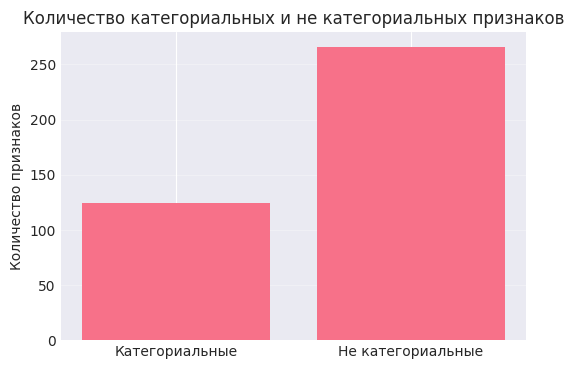

In [72]:
labels = ['Категориальные', 'Не категориальные']
values = [len(cats['total']), train_data.shape[1] - len(cats['total'])]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.title("Количество категориальных и не категориальных признаков")
plt.ylabel("Количество признаков")
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Категориальные признаки

Оценим 18 категориальных признаков с типом object, и постром кардинальность категориальных признаков.

In [73]:
# избавимся от шума в данных, которые во время анализа были найдены 
def normalize_value_obj(series: pd.Series, missing_tokens: dict = None) -> pd.Series:
    """Избавимся от все шумных даннных в категориальных признаков"""
    
    if missing_tokens is None:
        missing_tokens = {"no data", "nan", "none", "n/a", "na", "#!", ""}

    s = series.astype(str).str.strip().str.lower()
    s = s.replace(list(missing_tokens), np.nan)
    
    s = s.replace("nan", np.nan)
    return s



def detect_and_summarize_series(
    series: pd.Series,
    normalize: bool = True,
    decimal_comma: bool = True,
    numeric_threshold: float = 0.9,
) -> dict:
    """
    Сводка по серии + определение numeric-like
    """
    s = series.copy()

    # Базовые метрики
    n_unique = int(s.nunique(dropna=True))
    pct_missing = float(s.isna().mean())
    top_values = s.value_counts(dropna=True).head(5).to_dict()
    is_binary = n_unique <= 2

    # Оценка numeric-like
    tmp = s.dropna().astype(str)
    if tmp.empty:
        is_numeric_like = False
    else:
        if decimal_comma:
            tmp = tmp.str.replace(",", ".", regex=False)
        conv = pd.to_numeric(tmp, errors="coerce")
        success_ratio = float(conv.notna().mean()) if len(conv) > 0 else 0.0
        is_numeric_like = success_ratio >= float(numeric_threshold)

    return {
        "n_unique": n_unique,
        "pct_missing": pct_missing,
        "top_values": top_values,
        "is_binary": is_binary,
        "is_numeric_like": is_numeric_like,
    }

def metric_report_obj_to_df(metric_report: dict) -> pd.DataFrame:
    """
    Преобразует вложенный словарь metric_report в DataFrame
    """
    records = []
    
    for col, info in metric_report.items():
        rec = {
            "column": col,
            "n_unique": info.get("n_unique"),
            "pct_missing": info.get("pct_missing"),
            "top_values": info.get("top_values", {}),
            "is_binary": info.get("is_binary", False),
            "is_numeric_like": info.get("is_numeric_like", False),
        }
        records.append(rec)
    
    df = pd.DataFrame.from_records(records)
    return df


# нормализуем object-признаки
train_data[cats['object']] = train_data[cats['object']].apply(normalize_value_obj)

# генерируем метрики по obj
metric_report = {col: detect_and_summarize_series(train_data[col]) for col in cats['object']}

# преобразуем в DataFrame для obj / numeric
df_obj_metrics = metric_report_obj_to_df(metric_report)

In [74]:
df_obj_metrics.sample(4)

,column,n_unique,pct_missing,top_values,is_binary,is_numeric_like
7,modern_education_share,3,0.184,"{'93,08': 13662, '90,92': 7978, '95,4918': 3239}",False,True
3,culture_objects_top_25,2,0.000,"{'no': 28543, 'yes': 1928}",True,False
1,big_road1_1line,2,0.000,"{'no': 29690, 'yes': 781}",True,False
16,thermal_power_plant_raion,2,0.000,"{'no': 28817, 'yes': 1654}",True,False


визуализируем кардинальность категориальных признаков

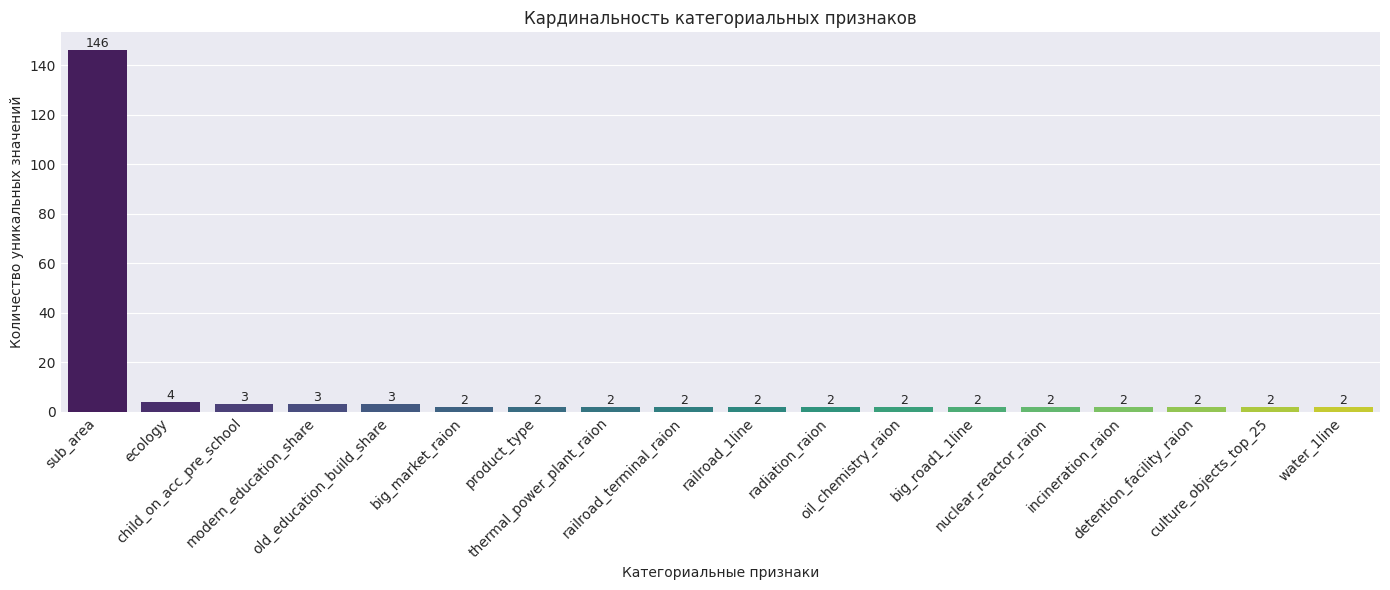

In [75]:
df_obj_sorted = df_obj_metrics.sort_values(by='n_unique', ascending=False)


def barplot_top_unique_values(df: pd.DataFrame, topk: int = 20):
    """Визуализирует топ-k признаков по количеству уникальных значений."""
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(
        x='column',
        y='n_unique',
        data=df.head(topk),
        palette='viridis'
    )
    
    # Добавляем аннотации со значениями на каждый столбец
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.0f}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            fontsize=9
        )
    
    plt.xticks(rotation=45, ha='right')
    plt.title('Кардинальность категориальных признаков')
    plt.ylabel('Количество уникальных значений')
    plt.xlabel('Категориальные признаки')
    plt.tight_layout()
    plt.show()


barplot_top_unique_values(df_obj_sorted, topk=20)

Категориальный признак типа object с высокой кардинальностью –– sub_area.

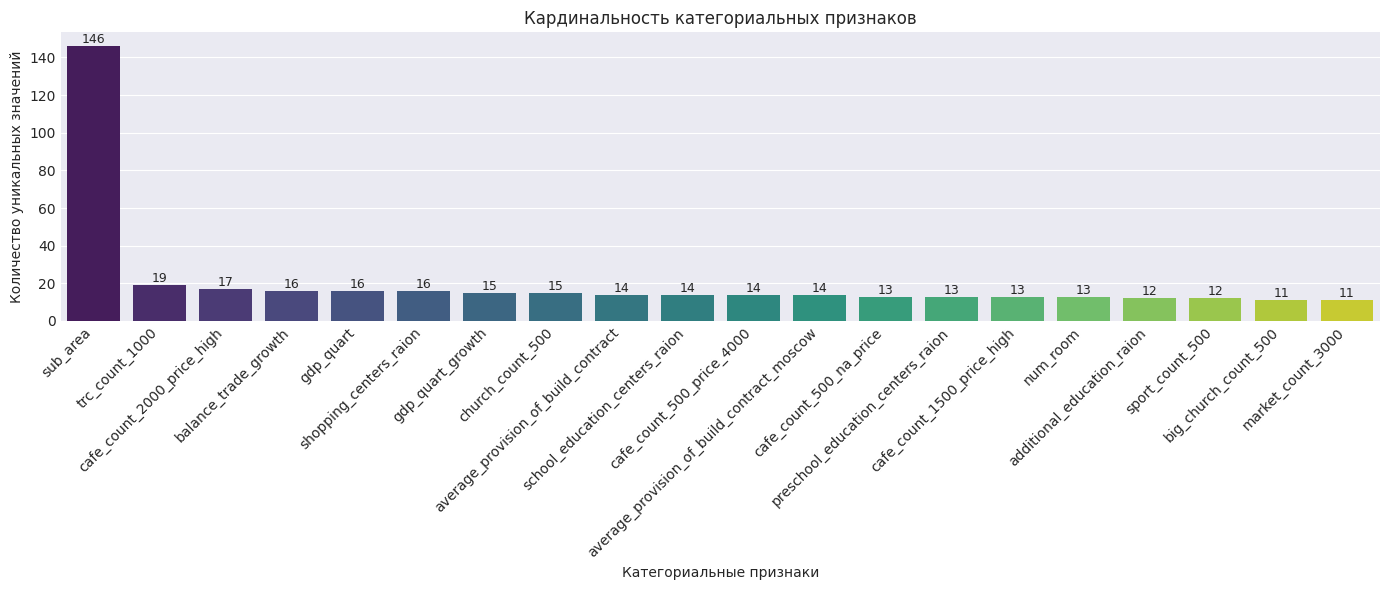

In [76]:
# cписок числовых категориальных признаков
numeric_cat_cols = [
    col for col in train_data.columns 
    if col not in cats['object'] 
    and col != 'timestamp' 
    and col in cats['numeric']
    and col not in ['id', 'ID_bus_terminal', 'ID_railroad_terminal']
]

numeric_unique_counts = train_data[numeric_cat_cols].nunique().sort_values(
    ascending=False
)
df_unique_counts = numeric_unique_counts.reset_index()
df_unique_counts.columns = ['column', 'n_unique']

df_cats = pd.concat(
    [
        df_unique_counts,
        df_obj_sorted[['column', 'n_unique']]
    ],
    axis=0
).sort_values(by='n_unique', ascending=False)

barplot_top_unique_values(df_cats, topk=20)

Признаки с высокой кардинальностью: 
- sub_area: показывает уникальных районов города;
- trc_count_1000: показывает количество торговых центров в радиусе 1000 метров;
- cafe_count_2000_price_high: показывает количество кафе высокого ценового сегмента в радиусе 2000 метров.

#### Пропущенные значения
Посмотрим на пропущенные значения в признаках

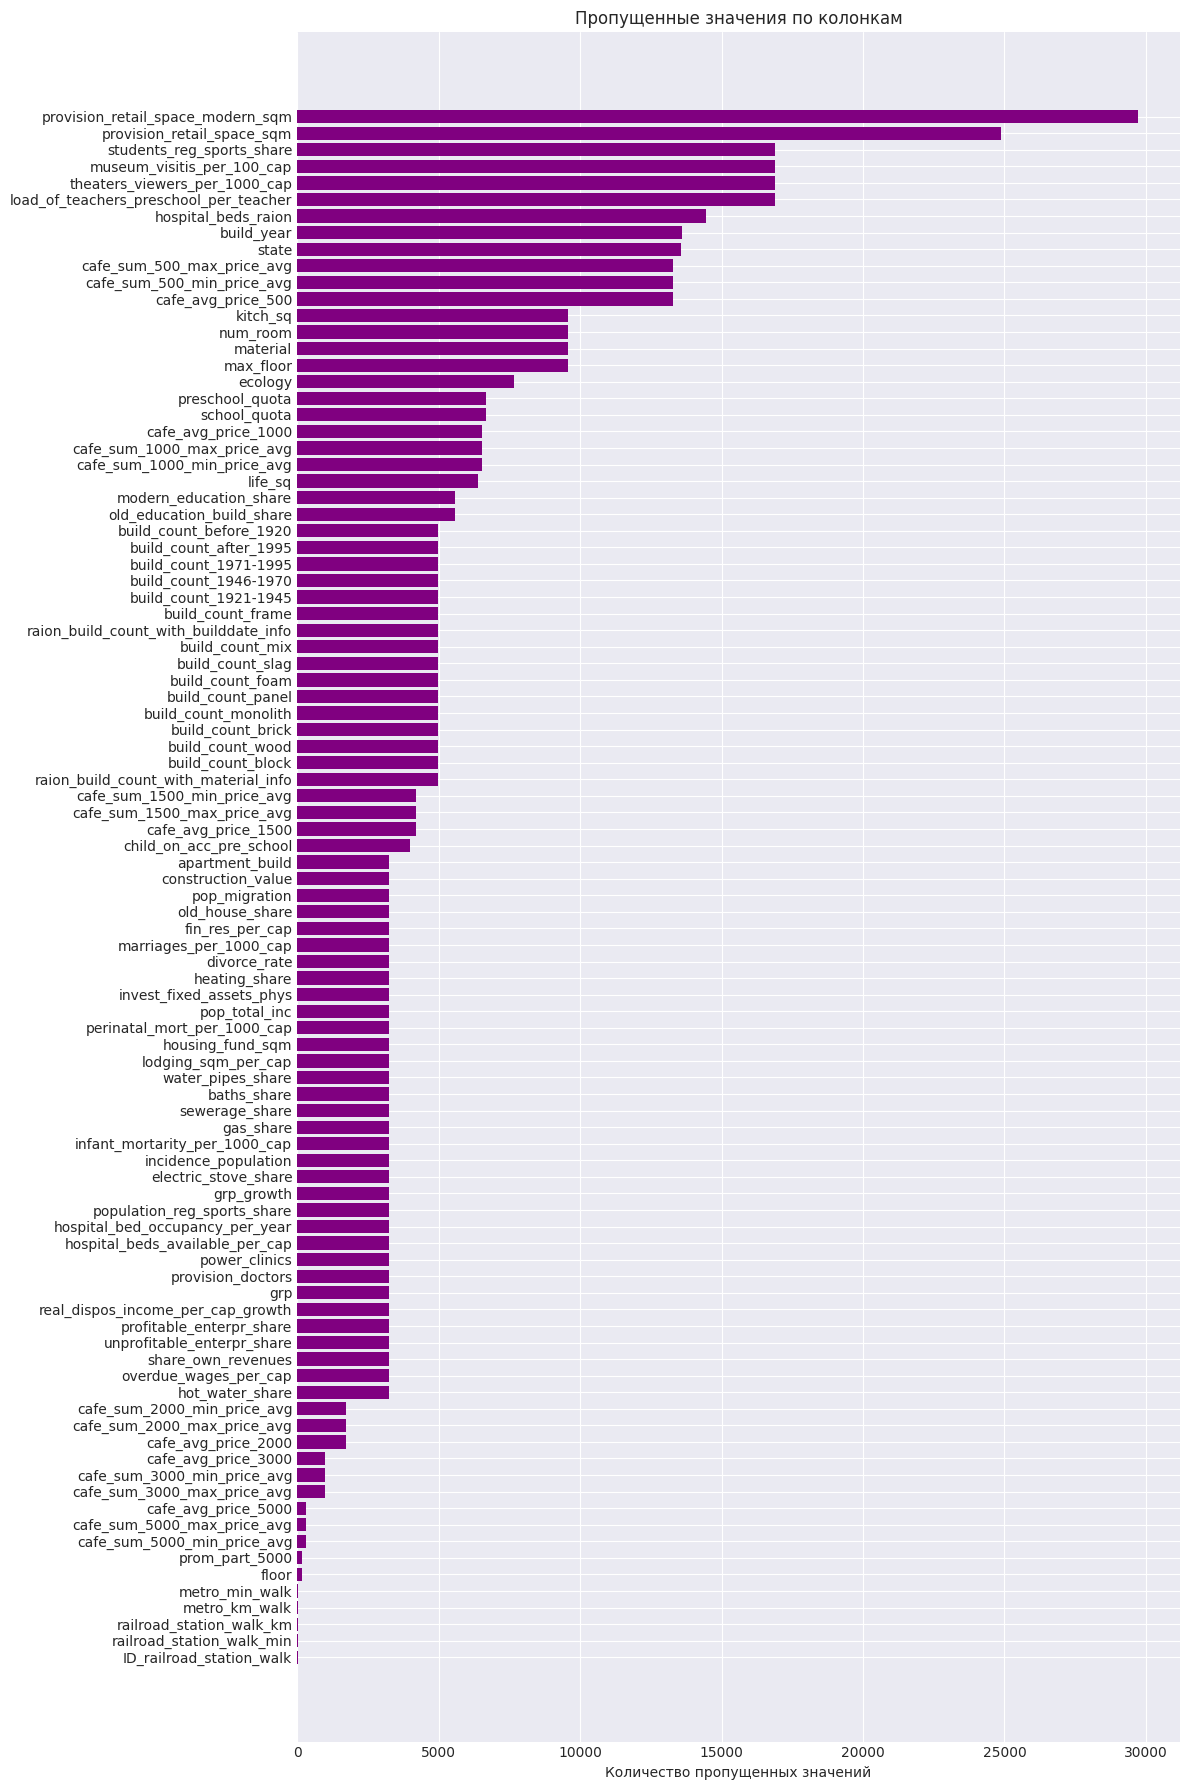

In [77]:
# Подсчёт пропущенных значений
missing_data = (
    train_data.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'column_name', 0: 'missing_count'})
)
missing_data = missing_data[missing_data['missing_count'] > 0] \
    .sort_values(by='missing_count')

# Построение горизонтальной гистограммы
fig, ax = plt.subplots(figsize=(12, 18))
ax.barh(
    missing_data['column_name'],
    missing_data['missing_count'],
    color='purple'
)
ax.set_xlabel('Количество пропущенных значений')
ax.set_title('Пропущенные значения по колонкам')
plt.tight_layout()
plt.show()

In [78]:
# вычисляем долю пропусков
missing_data["ratio"] = (
    missing_data["missing_count"] / len(train_data)
) * 100

# сортируем по убыванию (от max к min)
missing_data = missing_data.sort_values(by="missing_count", ascending=False)

# выбираем топ 20 признака с max(пропущенным значением)
top20_missing = missing_data.head(20)


# визулизируем
dprint(
    'Топ-20 признаков с высокой долей пропущенных значений',
    top20_missing
)

print('Общее количество признаков с пропущенными значениями: ', len(missing_data['column_name'].unique()))

,column_name,missing_count,ratio
378,provision_retail_space_modern_sqm,29718,97.529
377,provision_retail_space_sqm,24879,81.648
385,students_reg_sports_share,16901,55.466
382,museum_visitis_per_100_cap,16901,55.466
380,theaters_viewers_per_1000_cap,16901,55.466
365,load_of_teachers_preschool_per_teacher,16901,55.466
23,hospital_beds_raion,14441,47.393
6,build_year,13605,44.649
9,state,13559,44.498
159,cafe_avg_price_500,13281,43.586


Общее количество признаков с пропущенными значениями:  94


Довольно показательно, что есть признаки, которые практически полностью состоят из пропущенных значений.   
Стоит удалить признаки, которые содержат 50% процентов пропущенных значений, поскольку они неинформативны.

#### Коллинеарность и корреляция

Optimization Progress:   1%|▌                                                           | 1/101 [26:14<43:44:58, 1574.98s/it, best_trial=0, best_value=-0.0291]


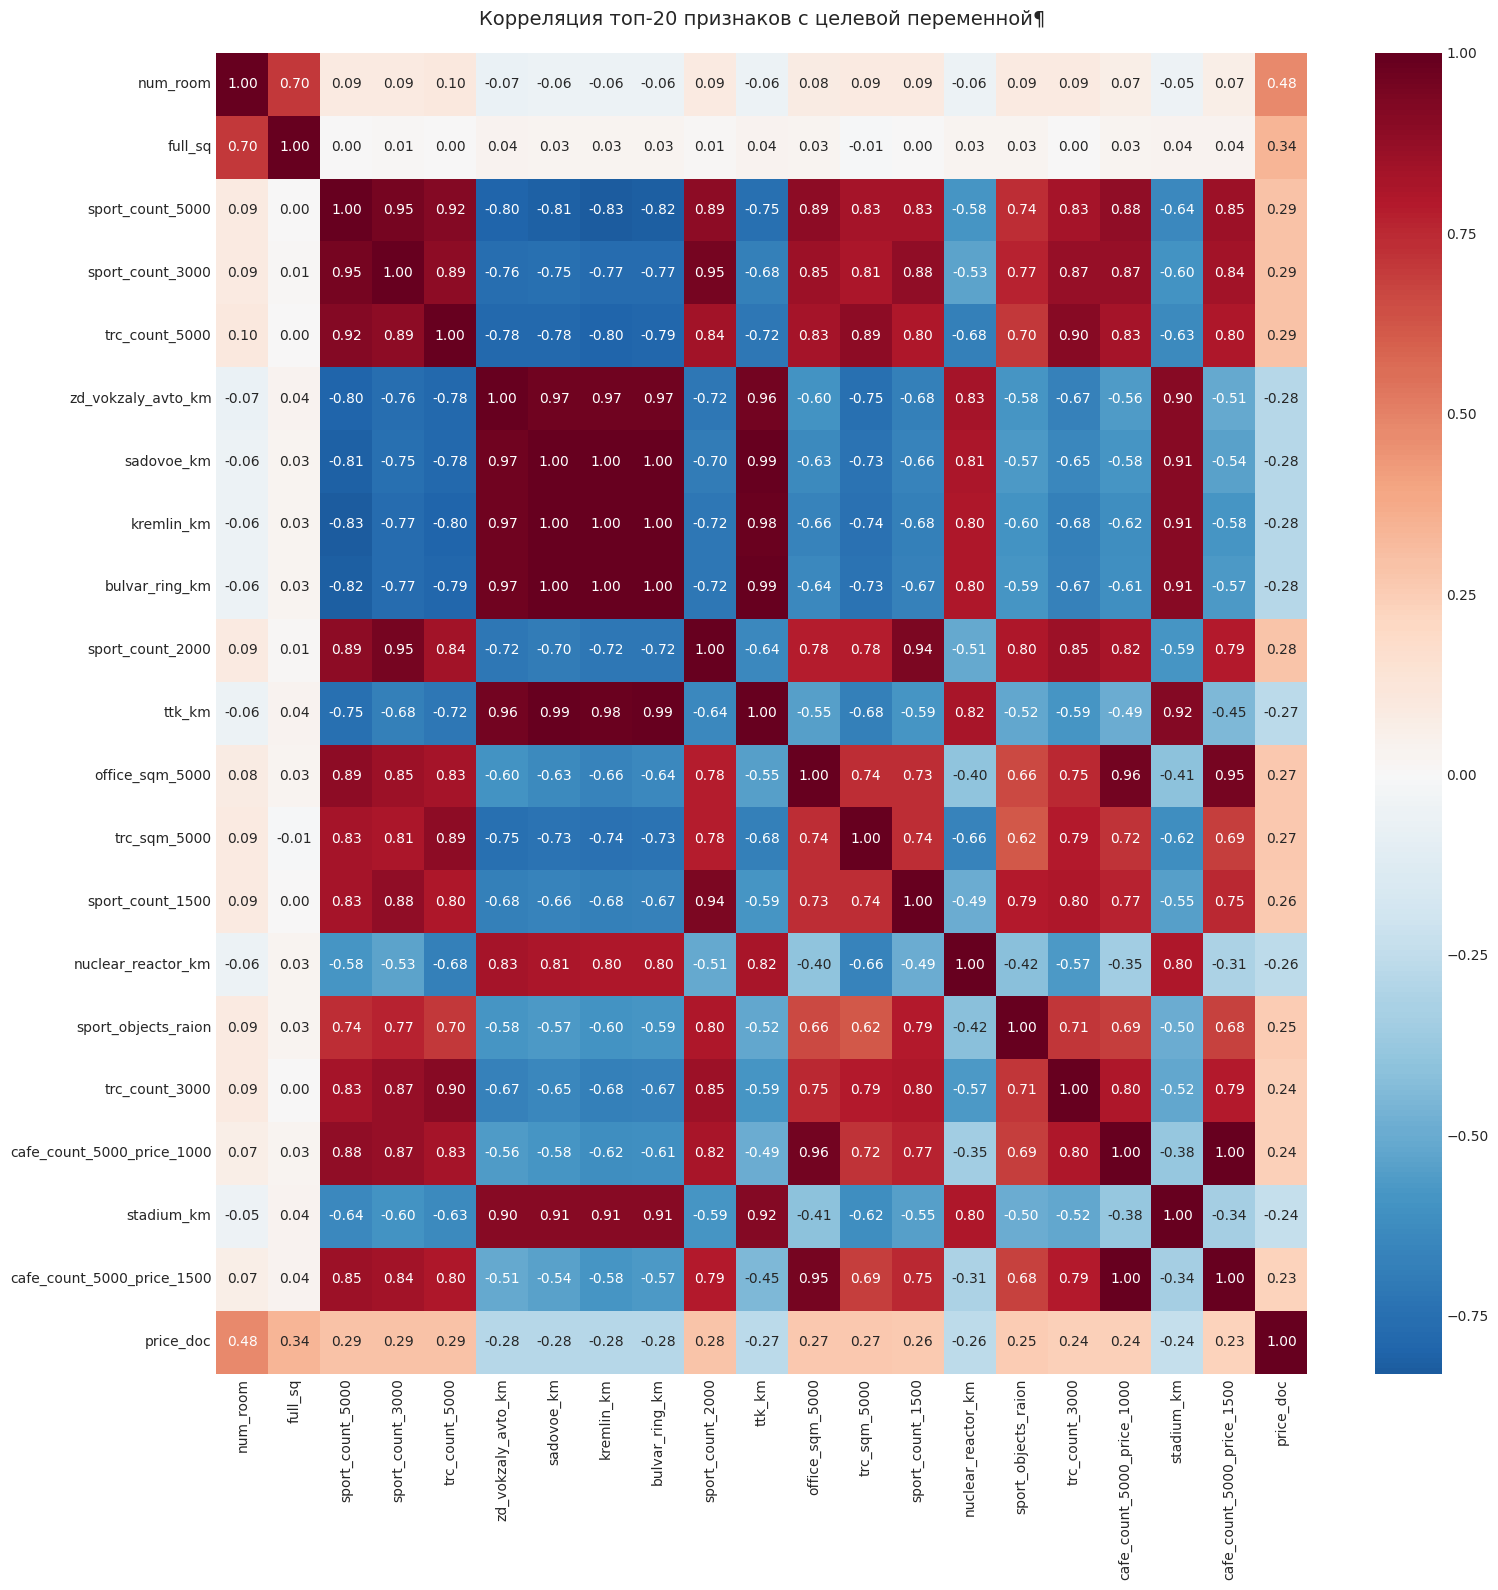

In [79]:
# посмотрим на корреляция признаков с целевой переменной¶

plt.figure(figsize=(16, 16))

top_n = 20
numeric_columns = train_data.select_dtypes(include=[np.number, np.float32]).columns
top_features = train_data[numeric_columns].corr()['price_doc'].abs().sort_values(ascending=False).index[1:top_n+1]
corr_matrix = train_data[top_features.tolist() + ['price_doc']].corr()

sns.heatmap(corr_matrix.round(2), annot=True, cmap='RdBu_r', center=0, 
            annot_kws={"size": 10}, fmt='.2f')
plt.title(f'Корреляция топ-{top_n} признаков с целевой переменной¶', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Можно выделить следующие корреляции между признаками:

- num_room и full_sq: существует сильная положительная корреляция, что логично — чем больше площадь квартиры, тем больше вероятность, что в ней будет больше комнат.

- num_room и price_doc: также наблюдается положительная связь, так как квартиры с большим количеством комнат обычно стоят дороже.

- trc_count / sport_count и price_doc: между количеством торговых и спортивных объектов поблизости и ценой квартиры возникает положительная корреляция. Чем больше таких объектов рядом, тем район удобнее для жизни, выше спрос и, соответственно, цена.

- other features(like tadium_km, bulvar_ring_km): эти признаки показывают отрицательную корреляцию с ценой. Чем дальше квартира от стадиона или бульварного кольца, тем ниже престиж района и удобство проживания, что отражается на стоимости жилья.

Попробуем найти мультиколлинеарность между признаками.

In [80]:
# найдем сильно коррелированные признаки ( corr(features) > 0.99 )

corr_matrix = train_data[numeric_columns].corr().abs()

def get_high_corr_pairs(corr_matrix, threshold: float = 0.3):
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):        
        for j in range(i + 1, len(corr_matrix.columns)):
            if corr_matrix.iloc[i, j] >= threshold:
                col1, col2 = corr_matrix.columns[i], corr_matrix.columns[j]
                corr_value = corr_matrix.iloc[i, j]
                
                high_corr_pairs.append({'feature_1': col1, 'feature_2': col2, 'corr': corr_value})
    return high_corr_pairs

df_high_corr_pairs = pd.DataFrame(get_high_corr_pairs(corr_matrix))

In [81]:
dprint(
    title="Сильно коррелированные признаки (c целевой переменной)", 
    df=df_high_corr_pairs.query("feature_2 == 'price_doc'").sort_values(['corr'], ascending=False)
)

dprint(
    title="Сильно коррелированные признаки", 
    df=df_high_corr_pairs.sort_values(['corr'], ascending=False).head()
)

,feature_1,feature_2,corr
3,num_room,price_doc,0.476
1,full_sq,price_doc,0.342


,feature_1,feature_2,corr
14188,baths_share,old_house_share,1.0
14064,childbirth,baths_share,1.0
14642,provision_retail_space_sqm,apartment_build,1.0
14297,heating_share,old_house_share,1.0
13044,grp,provision_retail_space_sqm,1.0


In [85]:
print('Количество пар с высокой корреляцией:')
df_high_corr_pairs.query('corr >= 0.99').shape[0]

Количество пар с высокой корреляцией:


395

Построим box-plot для признаков num_room и full_sq

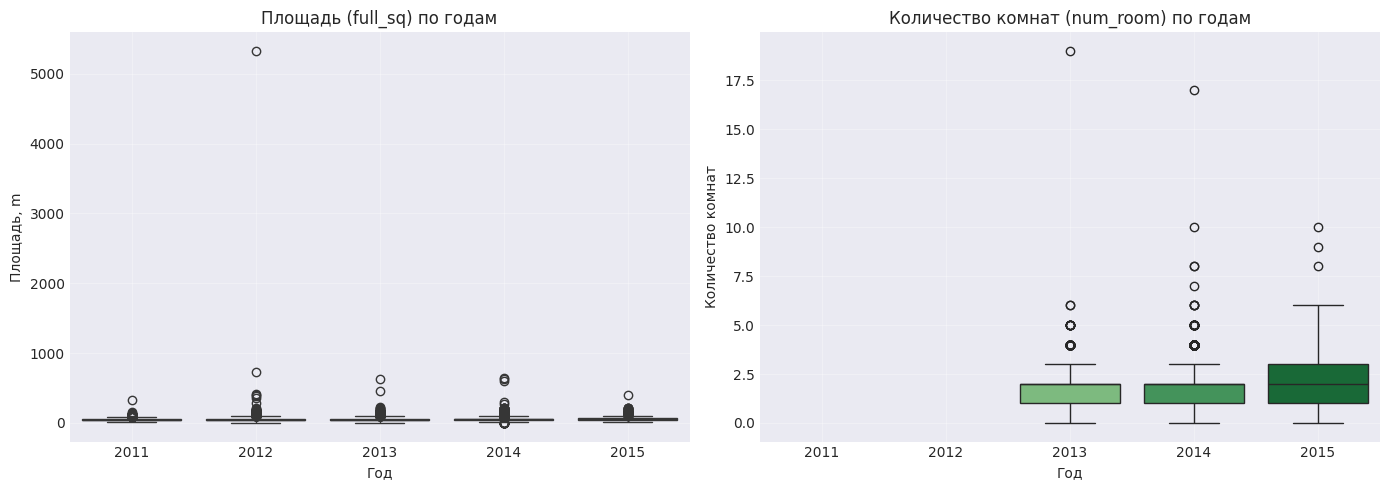

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='year', y='full_sq', data=train_data, ax=axes[0], palette='Blues')
axes[0].set_title('Площадь (full_sq) по годам')
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Площадь, m')
axes[0].grid(True, alpha=0.3)

sns.boxplot(x='year', y='num_room', data=train_data, ax=axes[1], palette='Greens')
axes[1].set_title('Количество комнат (num_room) по годам')
axes[1].set_xlabel('Год')
axes[1].set_ylabel('Количество комнат')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Лог-распределение цен')

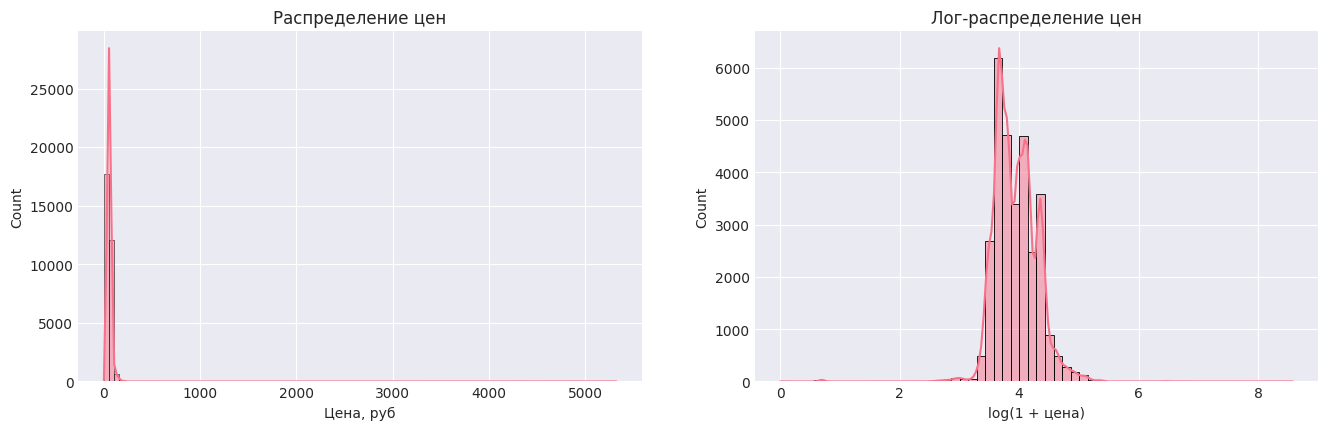

In [87]:
plt.figure(figsize=(16, 10))

# Гистограмма цены
plt.subplot(2, 2, 1)
sns.histplot(train_data['full_sq'], bins=100, kde=True)
plt.xlabel('Цена, руб')
plt.title('Распределение цен')

# Гистограмма лог-цены
plt.subplot(2, 2, 2)
sns.histplot(np.log1p(train_data['full_sq']), bins=60, kde=True)
plt.xlabel('log(1 + цена)')
plt.title('Лог-распределение цен')

Вероятно, в 2011–2012 годах информация о количестве комнат в квартирах не регистрировалась систематически. Тем не менее, можно попробовать восстановить эти значения, используя доступные за весь период наблюдений данные: район (sub_area), этаж (floor), год постройки (build_year) и общую площадь (full_sq).

Также в данных наблюдаются потенциальные аномалии:

- есть квартиры, количество комнат в которых значительно превышает медианное значение;

- встречаются записи, где количество комнат указано как нулевое (num_room == 0).

При этом квартиры с num_room ≤ 20, на мой взгляд, не следует считать выбросами, поскольку в 2016 году в Москве действительно была зафиксирована квартира с 20 комнатами ([источник](https://www.mirkvartir.ru/journal/analytics/2016/08/22/samaa-mnogokomnatnaa-kvartira-v-rossii-sostoit-iz-20-pomesenii/?utm_source=chatgpt.com&utm_referrer=https%3A%2F%2Fchatgpt.com%2F)). Такие значения крайне редки, но реально существуют и не являются аномалией.

Напротив, квартиры с num_room == 0 стоит рассматривать как выбросы или ошибки данных, поскольку жилое помещение без комнат не имеет физического смысла.

#### Выводы по анализу признаков
В данных довольно много пропущенных значений, поэтому стоит проверить корреляцию пропущенных значений с целевой переменной. 
##### **1. Тип данных**
Распределение типов данных:
- Непрерывные числовые (float64): 213 признаков
- Целочисленные (int64): 157 признаков
- Категориальные (object): 18 признаков
- Дата/время (datetime): 1 признак

Категоризация признаков:
- Явные категориальные признаки: 18 (тип object)
- Числовые категориальные признаки: 105 (числовые с ≤20 уникальными значениями)

Таким образом, категориальных признаков и непрерывных числовых составляется 123 и 266, соответственно.


##### **2. Категориальные признаки**
Наглядно видно, что большинство категориальных признаков типа object (за исключением: sub_area, ecology, child_on_acc_pre_school, modern_education_share, big_market_raion) являются бинарными (yes/no).
Это означает, что для них наиболее уместно использовать простое бинарное кодирование, то есть маппинг в формат 0/1.

1) **ecology**: стоит использовать ordinal encoding, поскольку данный признак имеет упорядоченный набор категорий: poor < satisfactory < good < excellent.

2) **sub_area**: Наиболее корректным решением будет использование target encoding в сочетании с out-of-fold, так как данный признак напрямую влияет на стоимость жилья и демонстрирует заметную зависимость от целевой переменной price_doc, которая на промежутке времени меняется (timestamp). То есть важно избежать утечки информации между обучением и валидацией.


3) **child_on_acc_pre_school**, **modern_education_share**, **big_market_raion**: Эти признаки формально числовые, но в данных они представлены как строки с разделителями, поэтому они были классифицированы как категориальные.
После нормализации они превращаются в числовые признаки и могут обрабатываться как numeric, поэтому:
    
- child_on_acc_pre_school — стоит использовать float и масштабировать;
- modern_education_share — также стоит переводить в число;
- old_education_build_share — тоже самое.


##### **3. Пропущенные признаки**
94 из 389 признаков содержат пропущенные значения, из которых наблюдаются с высокой долей пропусков (например, 97.529).
Подобные принаки явяляются неинформативными, поэтому стоит от них избавляться по следующему правилу, например признаки, которые содержать пропущенные значения больше 50% (nan_count > 50%) будут удалены.   

Методы заполнения пропущенных значений:

-  **категориальные признаки**: мода по сегментам (район + тип квартиры + timestamp и тд.);
-  **числовые признаки**: медианное значение по аналогичным объектам.


Также во время анализа целевой переменной стало ясно, что между количеством пропущенных значений и price_dot существует линейно отрицательная взаимосвязь.   
**Гипотеза**: дешевые квартиры имеют менее полное описание в базе данных.   

Можно использовать данный признак в качестве новой фичи + использовать модели, которые имеют встроенную поддержку к nan-значений (CatBoost, LightGBM).

##### **4. Коллинеарность и корреляция**

В ходе анализа было выявлено, что многие признаки имеют высокую взаимную корреляцию. В частности, обнаружено около 390 пар признаков с коэффициентом корреляции ≥ 0.99, что указывает на выраженную мультиколлинеарность. Наличие такой зависимости может существенно искажать результаты линейных моделей.

Для снижения влияния мультиколлинеарности целесообразно рассмотреть следующие подходы:

- **Агрегация признаков**: объединение сильно скоррелированных переменных в один обобщённый признак;
- **Использование моделей на основе деревьев решений**: такие алгоритмы менее чувствительны к мультиколлинеарности, поскольку способны учитывать нелинейные зависимости между признаками.

Кроме того, анализ показал, что лишь два признака имеют корреляцию с целевой переменной на уровне ≥ 0.3 — `num_room` и `full_sq`. Это свидетельствует тому, что взаимосвязь большинства признаков с целевым показателем носит нелинейный характер. В связи с этим для решения задачи целесообразно использовать модели, способные выявлять нелинейные зависимости, в частности градиентный бустинг.

## Model

### LightAutoML (LAMA)

In [88]:
# Логирование
def setup_logger(name='Sberbank_Russian_Housing_Market'):
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    if not logger.handlers:
        handler = logging.StreamHandler(sys.stdout)
        formatter = logging.Formatter(
            '%(asctime)s - %(levelname)s - %(message)s'
        )
        handler.setFormatter(formatter)
        logger.addHandler(handler)
    return logger


logger = setup_logger()

In [89]:
# Данные
DATA_DIR = Path('./data/raw')

train_data = pd.read_csv(DATA_DIR / 'train.csv')
test_data = pd.read_csv(DATA_DIR / 'test.csv')
macro_data = pd.read_csv(DATA_DIR / 'macro.csv')

train_data = pd.merge(train_data, macro_data, how='left', on='timestamp')
test_data = pd.merge(test_data, macro_data, how='left', on='timestamp')

# Поменяем тип на datetime
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

# Избавимся от ненужных признаков
drop_cols = ['ID_bus_terminal', 'ID_railroad_terminal', 'id']
train_data.drop(columns=drop_cols, inplace=True)
test_data.drop(columns=drop_cols, inplace=True)

print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (30471, 388)
Test shape: (7662, 387)


In [90]:
# определим роли признаков, все признаки, которые будут иметь уникальных 
# значений меньше 20 будут считаться категориальным
categorical_features = find_categorical_features(train_data, max_unique=20, exclude=exclude)

#### Configs

Относительно параметра switch будем менять параметры конфигов.

**Стратегия 1:**  

- timeout: 1 час
- general_params: None (на протяжение 1 часа будем использовать все доступные алгоритмы LightAutoML)

**Стратегия 2:**  
- timeout: 30 минут
- general_params: {'use_algos': ['lgb', 'cb']} (на протяжение 30 минут будем использовать LightGBM + CatBoost)

In [101]:
def run_lama_baseline(
    name: str,
    data: tuple[pd.DataFrame, pd.DataFrame],
    categorical_features: list, 
    switch: bool = True
):

    logger.info("="*60)
    logger.info(f"Starting LAMA baseline: {name}")
    logger.info("="*60)

    
    train = data.copy()
    train['price_log'] = np.log1p(train['price_doc'])

    task = Task(name='reg', loss='mse', metric='rmsle')
    roles = {
        'target': 'price_log',
        'drop': ['price_doc', 'ID_bus_terminal','ID_railroad_terminal', 'id'],
        'category': categorical_features
    }
    
    ts_cv = TimeSeriesIterator(
        datetime_col=train['timestamp'], 
        n_splits=3 
    )

    automl = TabularAutoML(
        task=task,
        timeout=3600 if switch else 1800,
        cpu_limit=4,
        gpu_ids='0,1,2,3',
        general_params={'use_algos': [['lgb', 'cb']]} if not switch else None,
        reader_params={'random_state': SEED, 'n_jobs': 4} if not switch else {'random_state': SEED}
    )

    oof_pred = automl.fit_predict(
        train, 
        roles=roles, 
        cv_iter=ts_cv, 
        verbose=1
    )

    oof_pred_price = np.expm1(oof_pred.data[:, 0])
    
    # убирает все NaN из предсказаний.
    mask = ~np.isnan(oof_pred_price)
    score = np.sqrt(
        mean_squared_log_error(
            train.loc[mask, 'price_doc'],
            oof_pred_price[mask]
        )
    )
    
    logger.info("--"*60)
    logger.info(f"OOF RMSLE: {score:.5f}")
    logger.info("--"*60)
    
    logger.info("="*60)
    logger.info(f"Finished LAMA baseline: {name}")
    logger.info("="*60)
    
    return automl, {
        'oof_log': oof_pred,
        'oof': oof_pred_price,
        'rmsle': score
    }

In [102]:
model1, report_scores1 = run_lama_baseline(name="basic", categorical_features=categorical_features['total'], data=train_data)

2025-12-15 11:39:16,051 - INFO - ============================================================
2025-12-15 11:39:16,052 - INFO - Starting LAMA baseline: basic
2025-12-15 11:39:16,052 - INFO - ============================================================
[11:39:16] Stdout logging level is INFO.
[11:39:16] Task: reg

[11:39:16] Start automl preset with listed constraints:
[11:39:16] - time: 3600.00 seconds
[11:39:16] - CPU: 4 cores
[11:39:16] - memory: 16 GB

[11:39:16] Train data shape: (30471, 389)

[11:39:22] Layer 1 train process start. Time left 3593.92 secs
[11:39:26] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[11:39:30] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -0.031983051376082434
[11:39:30] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[11:39:30] Time left 3585.35 secs

[11:39:35] Selector_LightGBM fitting and predicting completed
[11:39:39] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[11:39:51] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 

Optimization Progress:  30%|███████████████████                                             | 30/101 [05:05<12:04, 10.20s/it, best_trial=15, best_value=-0.029]

[11:44:57] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[11:44:57] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...


[11:45:07] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = -0.030668772980011413
[11:45:07] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[11:45:08] Start fitting Lvl_0_Pipe_1_Mod_2_CatBoost ...
[11:45:31] Fitting Lvl_0_Pipe_1_Mod_2_CatBoost finished. score = -0.03055581346812171
[11:45:31] Lvl_0_Pipe_1_Mod_2_CatBoost fitting and predicting completed
[11:45:31] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ... Time budget is 300.00 secs


Optimization Progress:  22%|█████████████▋                                                 | 22/101 [05:02<18:05, 13.75s/it, best_trial=12, best_value=-0.0291]

[11:50:33] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[11:50:33] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[11:51:01] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = -0.030457729697312686
[11:51:01] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[11:51:01] Time left 2894.19 secs

[11:51:01] Layer 1 training completed.

[11:51:01] Blending: optimization starts with equal weights. Score = -0.0303894
[11:51:01] Blending: iteration 0: score = -0.0302894, weights = [0.         0.35963535 0.20555519 0.16678452 0.2680249 ]
[11:51:02] Blending: iteration 1: score = -0.0302893, weights = [0.         0.36102262 0.21033277 0.14829254 0.28035203]
[11:51:02] Blending: no improvements for score. Terminated.

[11:51:02] Blending: best score = -0.0302893, best weights = [0.         0.36102262 0.21033277 0.14829254 0.28035203]
[11:51:02] Automl preset training completed in 705.96 seconds

[11:51:02] Model description:
Final prediction for new objects (level 0) = 
	 0.36102 * (2 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.21033 * (2 averaged models Lvl_0_Pipe_1_Mod_1_Tu

In [103]:
model2, report_scores2 = run_lama_baseline(name="boosted", categorical_features= categorical_features['total'], data=train_data, switch=False)

2025-12-15 11:51:02,098 - INFO - ============================================================
2025-12-15 11:51:02,098 - INFO - Starting LAMA baseline: boosted
2025-12-15 11:51:02,099 - INFO - ============================================================
[11:51:02] Stdout logging level is INFO.
[11:51:02] Task: reg

[11:51:02] Start automl preset with listed constraints:
[11:51:02] - time: 1800.00 seconds
[11:51:02] - CPU: 4 cores
[11:51:02] - memory: 16 GB

[11:51:02] Train data shape: (30471, 389)

[11:51:12] Layer 1 train process start. Time left 1789.84 secs
[11:51:18] Selector_LightGBM fitting and predicting completed
[11:51:21] Start fitting Lvl_0_Pipe_0_Mod_0_LightGBM ...
[11:51:33] Fitting Lvl_0_Pipe_0_Mod_0_LightGBM finished. score = -0.030424110430683535
[11:51:33] Lvl_0_Pipe_0_Mod_0_LightGBM fitting and predicting completed
[11:51:33] Start fitting Lvl_0_Pipe_0_Mod_1_CatBoost ...
[11:51:57] Fitting Lvl_0_Pipe_0_Mod_1_CatBoost finished. score = -0.03055581346812171
[11:51:57] L

#### Результаты экспериментов
**Config 1:**

- timeout=3600
- use LightAutoML's algorithms (all)
- OOF RMSLE: 0.48483

**Config 2:**

- timeout=1800
- use LightAutoML's algorithms (only CatBoost + LightGBM)
- OOF RMSLE: 0.48567

**Вывод:** Относительно результата 1-й конфигурации будем пытаться сформировать решение, которое превозойдет текущий показатель.

###  Собственное решение (Manual)

#### Feature Engineering
Генерация новых признаков:

- **living_area_ratio:** отношение жилой площади к общей площади квартиры   
  Смысл: показывает, сколько реально жилой площади приходится на квартиру относительно всего помещения. Низкое значение может означать большую часть площади, занятую подсобными или нежилыми помещениями, что может снижать стоимость.

- **floor_ratio:** доля этажа относительно максимального этажа в доме   
  Смысл: отражает расположение квартиры внутри дома. Квартиры на верхних этажах часто дороже из-за вида и меньшего шума, а на нижних – дешевле. Нормализованное значение помогает учесть разные дома с разной этажностью.

- **rooms_per_total_sq:** отношение количества комнат к полной площади (num_room / full_sq)   
  Смысл: показывает плотность планировки — много комнат на маленькой площади может указывать на маленькие комнаты, что может снижать привлекательность квартиры.


- **amenities_per_1k_pop:** количество ключевых объектов инфраструктуры (кафе, торговые центры, офисы, спортивные объекты) на 1000 жителей района
  Смысл: оценивает плотность инфраструктуры в районе в радиусе 500 метров. Чем больше объектов на душу населения, тем выше удобство проживания, а значит и стоимость квартиры может быть выше.

In [14]:
class NewFeatures(BaseEstimator, TransformerMixin):
    """
    Класс для генерации признаков, связанных с количеством комнат, жилой площадью,
    этажностью и инфраструктурой.
    """
    def __init__(self, amenities_cols=None, pop_col='raion_popul'):
        
        if amenities_cols is None:
            self.amenities_cols = ['cafe_count_500', 'trc_count_500', 'office_count_500', 'sport_count_500']
        else:
            self.amenities_cols = amenities_cols
        self.pop_col = pop_col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # living_area_ratio
        X['living_area_ratio'] = X['life_sq'] / X['full_sq']
        
        # floor_ratio
        X['floor_ratio'] = X['floor'] / X['max_floor']
        
        # rooms_per_total_sq
        X['rooms_per_total_sq'] = X['num_room'] / X['full_sq']

        amenities_cols = [
            'cafe_count_500', 'trc_count_500', 'office_count_500', 'sport_count_500'
        ]
                
        # amenities_per_1k_pop
        X['amenities_per_1k_pop'] = X[self.amenities_cols].sum(axis=1) / X[self.pop_col] * 1000
        
        return X

#### Feature Preprocessing


Сформируем улучшения, которые удалось выявить во время EDA:

1) избавимся от неинформативных признаков, которые содержат >= 50% пропущенных значений;
2) преобразуем категориальные признаки учитывая их специфику, но предварительно заполним пропущенные знач;
3) уменьшим количество признаков, используя PCA для того, чтобы уменшить размер данных (касается сильно коррелированных между собой признаков >= 0.95).

##### 1. Удаление неинформативных признаков

In [15]:
def remove_features(X: pd.DataFrame) -> pd.DataFrame:
    """
    Удаляем признаки, которые имеют более 50% пропущенных значений.
    """
    X = X.copy()
    
    miss_ratio = X.isna().mean()
    drop_cols = miss_ratio[miss_ratio >= 0.5].index.tolist()
    X = X.drop(columns=drop_cols)
    
    return X


def remove_features_for_pipeline(X: pd.DataFrame) -> pd.DataFrame:
    """
    Обертка для использования в пайплайне.
    """
    return remove_features(X)

##### 2. Кодируем признаки учитывая их специфику

In [16]:
BINARY_MAPPING: Dict[str, int] = {
    "no": 0,
    "yes": 1,
    "owneroccupier": 0,
    "investment": 1,
}


class BinaryEncoder(BaseEstimator, TransformerMixin):
    """Бинарное кодирование для признаков типа да/нет или owner/investment."""

    def __init__(
        self,
        cols: Optional[List[str]] = None,
        exclude: Optional[List[str]] = None,
        mapping: Optional[Dict[str, int]] = None,
    ):
        self.cols = cols or []
        self.exclude = exclude or []
        self.mapping = mapping or BINARY_MAPPING

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for col in self.cols:
            if col in self.exclude:
                continue

            if col not in X.columns:
                logger.info("BinaryEncoder: колонка '%s' не найдена — пропущено", col)
                continue

            X[col] = (
                X[col]
                .astype(str)
                .str.strip()
                .str.lower()
                .map(self.mapping)
            )
            X[col] = X[col].astype("Int64")

        return X


class SklearnTargetEncoder(BaseEstimator, TransformerMixin):
    """Обёртка над category_encoders.TargetEncoder для целевого кодирования."""

    def __init__(self, cols: Optional[List[str]] = None, smoothing: int = 10):
        self.cols = cols or ["sub_area"]
        self.target_encoder = ce.TargetEncoder(cols=self.cols, smoothing=smoothing)

    def fit(self, X: pd.DataFrame, y=None):
        self.target_encoder.fit(X[self.cols], y)
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        te_df = self.target_encoder.transform(X[self.cols])
        for col in self.cols:
            X[col + "_te"] = te_df[col]

        X.drop(columns=self.cols, inplace=True, errors="ignore")
        return X


class OrdEncoder(BaseEstimator, TransformerMixin):
    """Порядковое кодирование для категориальных признаков с упорядоченной шкалой (например, ecology)."""

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or ["ecology"]
        self.ord_encoder = OrdinalEncoder(
            categories=[["poor", "satisfactory", "good", "excellent"]],
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            dtype=np.int32,
        )

    def fit(self, X: pd.DataFrame, y=None):
        self.ord_encoder.fit(X[self.cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        encoded = self.ord_encoder.transform(X[self.cols])
        for i, col in enumerate(self.cols):
            X[f"{col}_ord"] = encoded[:, i]

        X.drop(columns=self.cols, inplace=True, errors="ignore")
        return X


class StringNumericConverter(BaseEstimator, TransformerMixin):
    """Конвертация строковых чисел типа '1,234' в числовой формат float."""

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or []

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        for col in self.cols:
            if col not in X.columns:
                logger.info(
                    "StringNumericConverter: колонка '%s' не найдена — пропущено", col
                )
                continue

            X[col] = X[col].astype(str).str.replace(",", ".", regex=False).str.strip()
            X[col] = pd.to_numeric(X[col], errors="coerce")

        return X


class Scaler(BaseEstimator, TransformerMixin):
    """
    Обёртка над sklearn.StandardScaler, возвращает DataFrame
    с сохранением названий колонок и индексов.
    """

    def __init__(self, cols: Optional[List[str]] = None):
        self.cols = cols or []
        self.scaler = StandardScaler()

    def fit(self, X: pd.DataFrame, y=None):
        self.scaler.fit(X[self.cols])
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()
        X_scaled = self.scaler.transform(X[self.cols])
        X[self.cols] = pd.DataFrame(X_scaled, columns=self.cols, index=X.index)
        return X


class GroupImputer(BaseEstimator, TransformerMixin):
    """
    Заполняет пропущенные значения по медиане внутри группы.
    Если медиана группы отсутствует, используется глобальная медиана.
    """
    def __init__(self, cols: str | list[str] = '*', group_cols: list[str] = ['year', 'sub_area']):
        self.cols: str | list[str] = cols
        self.group_cols: list[str] = group_cols
        self.group_medians = None
        self.global_medians = None

        self._temp_year_created = False
        self.selected_cols = None

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()

        if 'year' in self.group_cols and 'year' not in X.columns:
            X['year'] = pd.to_datetime(X['timestamp']).dt.year
            self._temp_year_created = True

        if self.cols == '*':
            self.selected_cols = X.select_dtypes(include=['number']).columns.tolist()
        else:
            self.selected_cols = [c for c in self.cols if c in X.columns]

        self.group_medians = X.groupby(self.group_cols)[self.selected_cols].median()
        self.global_medians = X[self.selected_cols].median()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X = X.copy()

        if self._temp_year_created and 'year' not in X.columns:
            X['year'] = pd.to_datetime(X['timestamp']).dt.year

        for col in tqdm(self.selected_cols, desc='Заполняем пропущенные значения'):
            X[col] = X.groupby(self.group_cols)[col].transform(
                lambda g: g.fillna(g.median())
            )
            X[col] = X[col].fillna(self.global_medians[col])

        if self._temp_year_created:
            X.drop(columns=['year'], inplace=True)

        return X

##### 3. Уменьшаем размерность данных на основе сильно скоррелированных признаков

In [26]:
class HighCorrSelector(BaseEstimator, TransformerMixin):
    """
    Transformer, который выбирает числовые признаки с высокой корреляцией и 
    снижает размерность с помощью PCA.
    """
    
    def __init__(
        self, 
        n_components: int, 
        threshold: float = 0.8, 
        exclude: list = [], 
        seed: int = 22
    ):
        self.n_components = n_components
        self.threshold = threshold
        self.exclude = exclude
        self.seed = seed

        self.high_corr_pairs_ = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr'])
        self.num_cols_ = []
        self.pca = None
        self.pca_n_components_ = None

    def fit(self, X: pd.DataFrame, y=None):
        cols = [c for c in X.select_dtypes(include=[np.number]) if c not in self.exclude]
        corr_matrix = X[cols].corr().abs()

        # ищем пары с высокой корреляцией
        pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                val = corr_matrix.iloc[i, j]
                if val >= self.threshold:
                    col1 = corr_matrix.columns[i]
                    col2 = corr_matrix.columns[j]
                    pairs.append({'feature_1': col1, 'feature_2': col2, 'corr': float(val)})

        self.high_corr_pairs_ = pd.DataFrame(pairs)
        unique_features = pd.unique(
            self.high_corr_pairs_[['feature_1', 'feature_2']].values.ravel()
        )
        self.num_cols_ = [c for c in unique_features if c in X.columns]

        if len(self.num_cols_) == 0:
            self.pca_n_components_ = 0
            return self

        self.pca_n_components_ = min(self.n_components, len(self.num_cols_))
        self.pca = PCA(n_components=self.pca_n_components_, random_state=self.seed)
        self.pca.fit(X[self.num_cols_])
        return self

    def transform(self, X: pd.DataFrame):
        if self.pca_n_components_ == 0 or not self.num_cols_:
            return pd.DataFrame(index=X.index), []

        cols_to_use = [c for c in self.num_cols_ if c in X.columns]
        X_num = X[cols_to_use]

        pca_feat = self.pca.transform(X_num)
        df_pca = pd.DataFrame(
            pca_feat,
            columns=[f"PCA_{i}" for i in range(self.pca_n_components_)],
            index=X.index
        )

        cols_remaining = [col for col in X.columns if col not in self.num_cols_]
        res = pd.concat([X[cols_remaining], df_pca], axis=1).replace(
            [np.inf, -np.inf], np.nan
        ).fillna(0)
        return res, self.num_cols_

##### Формируем элементы pipeline для обработки данных

In [56]:
categorical_features = find_categorical_features(
    train_data, max_unique=20, exclude=exclude
)

binary_cols = [
    x for x in categorical_features['object'] + ['sub_area_te', 'ecology_ord']
    if x not in ['sub_area', 'ecology']
]

numeric_cols = [
    'child_on_acc_pre_school', 
    'modern_education_share', 
    'old_education_build_share'
]

def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))

#### Решение 1

Реализуем эксперимент с XGBoost Regressor. Через PCA снихим размерность исходноых данных и обучим модель.

In [20]:
from xgboost import XGBRegressor

preprocessor = Pipeline([
    ('rm', FunctionTransformer(remove_features_for_pipeline, validate=False)),
    ('str_num', StringNumericConverter(cols=numeric_cols)),
    ('impute', GroupImputer(cols="*", group_cols=['year', 'sub_area'])),
    ('scale', Scaler(cols=numeric_cols)),
    ('te', SklearnTargetEncoder(cols=['sub_area'])),
    ('ord', OrdEncoder(cols=['ecology'])),
    ('binary', BinaryEncoder(
        cols=categorical_features['object'],
        exclude=numeric_cols,
        mapping=BINARY_MAPPING
    ))
])

data = preprocessor.fit_transform(train_data, train_data['price_doc'])

X_train_prep = data.drop(columns=['price_doc', 'timestamp'])
y_train_prep = data['price_doc']

reduce = Pipeline([
    ('new_features', NewFeatures()),
    ('reduce', HighCorrSelector(
        n_components=150,
        exclude=[
            'living_area_ratio', 
            'floor_ratio', 
            'rooms_per_total_sq', 
            'amenities_per_1k_pop'
        ],
        seed=SEED
    ))
])

X_train_prep_reduce, _ = reduce.fit_transform(X_train_prep, y_train_prep)

X_train, X_test, y_train, y_test = train_test_split(
    X_train_prep_reduce,
    y_train_prep,
    test_size=0.2,
    random_state=SEED
)

Заполняем пропущенные значения: 100%|████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:54<00:00,  6.70it/s]


2025-12-15 09:42:14,537 - INFO - BinaryEncoder: колонка 'ecology' не найдена — пропущено
2025-12-15 09:42:14,625 - INFO - BinaryEncoder: колонка 'sub_area' не найдена — пропущено


In [21]:
def run_xgb_regressor(X_train, X_test, y_train, y_test, seed=22, verbose=False):
    model_params = {
        'n_estimators': 1000,
        'learning_rate': 0.03,
        'max_depth': 10,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'objective': 'reg:squarederror',
        'n_jobs': -1,
        'random_state': seed,
        'eval_metric': 'rmse'
    }

    model = XGBRegressor(**model_params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=verbose
    )

    y_pred = model.predict(X_test)
    test_rmsle = rmsle(y_test, y_pred)

    print("XGB Regressor")
    print(f"RMSLE: {test_rmsle:.6f}")
    return model, test_rmsle


result = run_xgb_regressor(
    X_train, X_test, 
    y_train, y_test, 
    seed=SEED
)

XGB Regressor
RMSLE: 0.456564


#### Решение 2

Будем использовать Stacking Regressor, который будет объединять три модели:

- Линейная модель (ElasticNet) — для захвата линейных зависимостей в данных.
- XGBoost — градиентный бустинг на деревьях, хорошо работает с нелинейными признаками.
- LightGBM — быстрый градиентный бустинг, дополняющий XGBoost.

В качестве финального оценщика используется Ridge, который обучается на предсказаниях трёх базовых моделей.

Для таргета применим логарифмическая трансформация (log1p) для стабилизации дисперсии и снижения влияния больших значений. Метрика оценки качества — RMSLE.

In [104]:
preprocessor = Pipeline([
    ('rm', FunctionTransformer(remove_features_for_pipeline, validate=False)),
    ('str_num', StringNumericConverter(cols=numeric_cols)),
    ('impute', GroupImputer(cols="*", group_cols=['year', 'sub_area'])),
    ('scale', Scaler(cols=numeric_cols)),
    ('te', SklearnTargetEncoder(cols=['sub_area'])),
    ('ord', OrdEncoder(cols=['ecology'])),
    ('binary', BinaryEncoder(
        cols=categorical_features['object'],
        exclude=numeric_cols,
        mapping=BINARY_MAPPING
    ))
])

data = preprocessor.fit_transform(
    train_data, 
    train_data['price_doc']
)

X_train_prep = data.drop(columns=['price_doc', 'timestamp'])
y_train_prep = data['price_doc']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_prep, y_train_prep, test_size=0.2, random_state=SEED
)

Заполняем пропущенные значения: 100%|████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:55<00:00,  6.57it/s]


2025-12-15 12:09:06,737 - INFO - BinaryEncoder: колонка 'ecology' не найдена — пропущено
2025-12-15 12:09:06,825 - INFO - BinaryEncoder: колонка 'sub_area' не найдена — пропущено


In [ ]:
data = preprocessor.fit_transform(
    train_data, 
    train_data['price_doc']
)

X_train_prep = data.drop(columns=['price_doc', 'timestamp'])
y_train_prep = data['price_doc']

X_train, X_test, y_train, y_test = train_test_split(
    X_train_prep, y_train_prep, test_size=0.2, random_state=SEED
)

In [23]:
def run_stacking_xgb_lgb_linear(
    X_train,
    X_test,
    y_train,
    y_test,
    random_state: int = 42,
):

    y_train_log = np.log1p(y_train)
    y_test_log = np.log1p(y_test)

    # Линейная модель без scaler
    linear_model = ElasticNet(
        alpha=0.001,
        l1_ratio=0.5,
        max_iter=5000,
        random_state=random_state
    )

    xgb_model = xgb.XGBRegressor(
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=1,             
        random_state=random_state,
        verbosity=0
    )

    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state
    )

    estimators = [
        ('linear', linear_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model),
    ]

    final_estimator = Ridge(alpha=0.1)

    stacking_reg = StackingRegressor(
        estimators=estimators,
        final_estimator=final_estimator,
        passthrough=False,
        n_jobs=1
    )

    stacking_reg.fit(X_train, y_train_log)

    y_pred_log = stacking_reg.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    score_rmsle = rmsle(y_test.values, y_pred)
    score_r2 = r2_score(y_test.values, y_pred)

    print(f"Stacking (XGB + LGBM + Linear)")
    print(f"RMSLE: {score_rmsle:.6f}")

    return score_rmsle, score_r2, stacking_reg


result = run_stacking_xgb_lgb_linear(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    random_state=SEED
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 44061
[LightGBM] [Info] Number of data points in the train set: 24376, number of used features: 380
[LightGBM] [Info] Start training from score 15.609901
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43713
[LightGBM] [Info] Number of data points in the train set: 19500, number of used features: 380
[LightGBM] [Info] Start training from score 15.607397
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43774
[LightGBM] [Info] Number of data points in the train set: 19501, number of used features: 380
[LightGBM] [Info] S

#### Решение 3
Используем CatBoost  
CatBoost эффективно обрабатывает категориальные признаки без необходимости явного кодирования, применяет ordered boosting для предотвращения утечки информации и имеет встроенные механизмы балансировки классов. Поэтому в данном решении мы не будем отдельно обрабатывать категориальные признаки и исключим из пайплайна все методы, предназначенные для их обработки.


In [24]:
preprocessor = Pipeline([
    ('rm', FunctionTransformer(remove_features_for_pipeline, validate=False)),
    ('str_num', StringNumericConverter(cols=numeric_cols)),
    ('impute', GroupImputer(cols="*", group_cols=['year', 'sub_area'])),
    ('scale', Scaler(cols=numeric_cols))
])

data = preprocessor.fit_transform(
    train_data, 
    train_data['price_doc']
)

X_train_prep = data.drop(columns=['price_doc', 'timestamp'])
y_train_prep = data['price_doc']

cat_cols = X_train_prep.select_dtypes(include=['object']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X_train_prep, y_train_prep, test_size=0.2, random_state=22
)

Заполняем пропущенные значения: 100%|████████████████████████████████████████████████████████████████████████████████████████| 367/367 [00:54<00:00,  6.70it/s]


In [25]:
def rmsle(y_true, y_pred):
    y_pred = np.clip(y_pred, a_min=0, a_max=None)
    return np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))


def run_catboost_regressor(
    X_train,
    y_train,
    X_test,
    y_test,
    cat_cols,
    seed: int,
):
    # зададим категориальные признаки
    train_pool = Pool(
        X_train,
        y_train,
        cat_features=cat_cols
    )
    val_pool = Pool(
        X_test,
        y_test,
        cat_features=cat_cols
    )

    model = CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=10,
        loss_function='RMSE',
        eval_metric='RMSE',
        early_stopping_rounds=200,
        random_seed=seed,
        verbose=200
    )
    model.fit(
        train_pool,
        eval_set=val_pool,
        use_best_model=True
    )

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    rmsle_train = rmsle(y_train, y_pred_train)
    rmsle_test = rmsle(y_test, y_pred_test)
    
    print("CatBoost")
    print(f"RMSLE: {rmsle_test:.5f}")

    return {
        'model': model,
        'rmsle_train': rmsle_train,
        'rmsle_test': rmsle_test,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test,
    }

results = run_catboost_regressor(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    cat_cols=cat_cols,
    seed=SEED
)

TBB Warning: The number of workers is currently limited to 9. The request for 255 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



0:	learn: 4748687.8208266	test: 4533437.9975065	best: 4533437.9975065 (0)	total: 145ms	remaining: 7m 15s
200:	learn: 2129591.7694506	test: 2683617.8316035	best: 2683617.8316035 (200)	total: 18.8s	remaining: 4m 21s
400:	learn: 1905636.4954902	test: 2612307.2106362	best: 2612307.2106362 (400)	total: 37.2s	remaining: 4m 1s
600:	learn: 1756135.9101074	test: 2584663.6578474	best: 2584471.9883897 (598)	total: 55.5s	remaining: 3m 41s
800:	learn: 1614658.9413935	test: 2574535.0759373	best: 2574535.0759373 (800)	total: 1m 14s	remaining: 3m 23s
1000:	learn: 1488941.0970040	test: 2569703.3585569	best: 2569696.7293713 (999)	total: 1m 33s	remaining: 3m 5s
1200:	learn: 1380107.4204579	test: 2567730.7241943	best: 2567573.2572832 (1191)	total: 1m 51s	remaining: 2m 47s
1400:	learn: 1268055.5636941	test: 2566371.5888717	best: 2566059.8263717 (1312)	total: 2m 10s	remaining: 2m 28s
1600:	learn: 1174459.4861093	test: 2565427.8533406	best: 2565098.9060961 (1512)	total: 2m 29s	remaining: 2m 10s
Stopped by ov

## **Итоги**
В рамках данного соревнования были реализованы два LAMA-бейзлайна и три manual-решений: XGBoost, Stacking Regressor и CatBoost.
C помощью ручного построения пайплайнов и EDA удалось превзойти результаты LAMA-бейзлайна во всех трех имплементациях.

Наилучший результат показал **Stacking Regressor**, объединивший три модели:
- Линейная модель
- XGBoost
- LightGBM

В качестве финального оценщика использовался Ridge, обученный на предсказаниях трёх базовых моделей. 
Для целевого признака применена логарифмическая трансформация (log1p), что стабилизирует дисперсию и снижает влияние выбросов.    


Результат:   

- **LAMA Baseline**    
RMSLE: 0.48483      

- **Stacking (XGB + LGBM + Linear)**  
RMSLE: 0.450828 

Итоговое улучшение: ~0.03 RMSLE. 

**Ключевые факторы получения лучшего результата:**
- избавления от неинформативных данных;
- manual-кодирование категориальных признаков;
- формирование новых фичей и заполнение пропущенных значений на основе взаимсвязанных признаков.

**Вывод:** AutoML — хорошая библиотека для быстрого получения качественных результатов, но обработка данных также играет ключевую роль в построении моделей, особенно при работе с "грязными данными".